## Step 1: Import Packages


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix

## Step 2: Load and Prepare Data


In [2]:
base_path = os.path.abspath("../data_directory/clean_data")

# Read the data
df_pipeline = pd.read_csv(os.path.join(base_path, "Pipeline.csv"))
df_accounts = pd.read_csv(os.path.join(base_path, "Accounts.csv"))

print("Cleaned data loaded successfully")
print(f"Pipeline shape: {df_pipeline.shape}")
print(f"Accounts shape: {df_accounts.shape}")

# Handle missing dates
df_pipeline['engage_date'] = pd.to_datetime(df_pipeline['engage_date'], errors='coerce')
df_pipeline['close_date'] = pd.to_datetime(df_pipeline['close_date'], errors='coerce')

# Replace missing close dates with a default (end of 2017)
current_date = pd.to_datetime('2017-12-31')
df_pipeline['lead_age_days'] = (
    df_pipeline['close_date'].fillna(current_date) - df_pipeline['engage_date']
).dt.days.clip(lower=0)

# Prevent negative values just in case
df_pipeline['lead_age_days'] = df_pipeline['lead_age_days'].clip(lower=0)


Cleaned data loaded successfully
Pipeline shape: (8800, 8)
Accounts shape: (85, 7)


## Step 3: Merge Data


In [3]:
df = df_pipeline.merge(df_accounts, on='account', how='left')
print(f"Merged data shape: {df.shape}")

Merged data shape: (8800, 15)


## Step 4: Features


In [4]:
df['converted'] = (df['deal_stage'].str.lower() == 'won').astype(int)

X = df[['revenue', 'employees', 'lead_age_days']].fillna(0)
y = df['converted']

print("\nFeature summary:")
print(f"Feature columns: {list(X.columns)}")
print(f"Label distribution:\n{y.value_counts()}")
print(f"Conversion rate: {y.mean():.2%}")



Feature summary:
Feature columns: ['revenue', 'employees', 'lead_age_days']
Label distribution:
converted
0    4562
1    4238
Name: count, dtype: int64
Conversion rate: 48.16%


## Step 5: Train-Test Split


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


print(f"\nTraining samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Training conversion rate: {y_train.mean():.2%}, Test conversion rate: {y_test.mean():.2%}")


Training samples: 6160, Test samples: 2640
Training conversion rate: 48.17%, Test conversion rate: 48.14%


## Step 6: Train the Gradient Boosted Decision Tree


In [6]:
print("Training GBDT Model...")
gbdt_model = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)
gbdt_model.fit(X_train, y_train)
print("Model training complete!")

Training GBDT Model...
Model training complete!



MODEL PERFORMANCE SUMMARY
────────────────────────────
Accuracy: 0.694 (69.36%)
AUC Score: 0.741

Classification Report:
               precision    recall  f1-score   support

Not Converted       0.88      0.48      0.62      1369
    Converted       0.62      0.93      0.74      1271

     accuracy                           0.69      2640
    macro avg       0.75      0.70      0.68      2640
 weighted avg       0.75      0.69      0.68      2640


Confusion Matrix:
                 Pred 0 (Lost)  Pred 1 (Won)
Actual 0 (Lost)            652           717
Actual 1 (Won)              92          1179


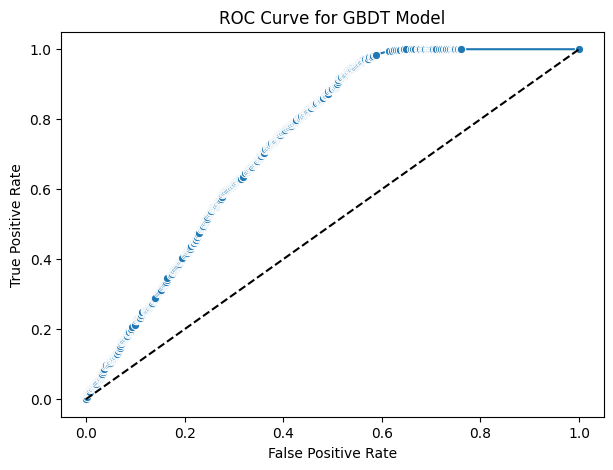

In [7]:
y_prob = gbdt_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = auc(fpr, tpr)

# Step 10: Display results neatly
print("\nMODEL PERFORMANCE SUMMARY")
print("────────────────────────────")
print(f"Accuracy: {acc:.3f} ({acc*100:.2f}%)")
print(f"AUC Score: {auc_score:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Converted', 'Converted']))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=['Actual 0 (Lost)', 'Actual 1 (Won)'],
    columns=['Pred 0 (Lost)', 'Pred 1 (Won)']
)
print("\nConfusion Matrix:")
print(cm_df)

# ROC Curve
plt.figure(figsize=(7, 5))
sns.lineplot(x=fpr, y=tpr, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for GBDT Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()